# Simple Example

## Setup

### Run the Data Preprocessing notebook once to import the get_data method

In [1]:
%run data_preprocessing.ipynb

### Run the Data Evaluation notebook once to import the show_evaluation method

In [2]:
%run data_evaluation.ipynb

### Imports

In [3]:
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, RFECV, RFE, SelectFwe

from sklearn.pipeline import Pipeline

### Hyperparmeters

In [4]:
# for get_data
enable_feature_engineering = True
enable_outlier_handling = True
normalize = 'minmax'
use_one_hot_encoding = True
split_size = (0.7, 0.0, 0.3)

# for the DummyClassifier
strategy = 'uniform'

### Get the data

In [5]:
y_train, x_train, y_val, x_val, y_test, x_test = get_data(enable_feature_engineering, enable_outlier_handling, normalize, use_one_hot_encoding, split_size)

Dropped 24 duplicate rows.
Dropped 86 rows -> height too low.
Dropped 1 rows -> height too high.
Dropped 2 rows -> weight too low.
Dropped 0 rows -> weight too high.
Dropped 186 rows -> systolic bp too low.
Dropped 47 rows -> systolic bp too high.
Dropped 40 rows -> diastolic bp too low.
Dropped 948 rows -> diastolic bp too high.
Dropped 103 rows -> sytolic bp was lower than diastolic.


## Model

### Create the model

In [6]:
# Function to create pipeline
def createPipeline(pol_degree=1, cvs=5, solver='sag', step=1, max_iter=100, x_train=None, y_train=None):

    # create and fit a linear regression using statistical gradient descent as default
    regr = linear_model.LogisticRegression(max_iter = 100, solver = solver)

    # Defining degree of polynomial combination transformation
    pol_degree = pol_degree

    # Creating object to transform set of features to a set of all polynomial combinations of the features
    transformer = PolynomialFeatures(degree=pol_degree, include_bias=False)

    # Test whether a cross validation should be applied
    if cvs > 1:
        # creating an object to conduct cross fold recursive feature elimination
        #  - sklearn.model_selection.StratifiedKFold is used per default
        #  - removing 1 feature at a time
        feature_selection = RFECV(regr, step=step, cv=cvs)
    
    # No cross validation (e.g. for greater feature set)
    else:
        
        # Defining a Function to selec thow many features shoulb be selected. 
        def get_n_features_to_select(x_train, y_train, alpha= 0.05): 
            f, pval = f_regression(transformer.fit_transform(x_train), y_train)
            n_features_to_select = len(pval[pval < alpha])
            return n_features_to_select
        
        feature_selection = RFE(regr, n_features_to_select= get_n_features_to_select(x_train, y_train), step=1)
        
    pipeline = Pipeline([ ('transformer', transformer), ('feature_selection', feature_selection)])

    return pipeline


In [7]:
# Function to describe which features were selected and/or ommited
def describeFeatureSelection(pipeline, X, print_only_ommited = True):
    
    # Selection of features - boolean list
    selection = pipeline.named_steps['feature_selection'].get_support()
    
    # List of all columns of the transofrmed dataset
    columns   = np.array(pipeline.named_steps['transformer'].get_feature_names(X.columns))
    
    if print_only_ommited == True:
        print('List of selected features:')
        for col in columns[selection]:
            print(' - ', col)

    print('\nList of gropped features:')
    for col in columns[selection == False]:
        print(' - ', col)

### Train the model

In [8]:
# Instantiating the pipeline
pipeline = createPipeline()

# Fitting the regression model
pipeline.fit(x_train, y_train)

# Print the selected and ommited features
describeFeatureSelection(pipeline, x_train, print_only_ommited = True)

List of selected features:
 -  age
 -  ap_hi
 -  ap_lo
 -  smoke
 -  alco
 -  active
 -  bmi
 -  cholesterol_1
 -  cholesterol_3
 -  gluc_3

List of gropped features:
 -  is_female
 -  cholesterol_2
 -  gluc_1
 -  gluc_2


In [9]:
# Instantiating the pipeline
pipeline_pol = createPipeline(pol_degree=2, cvs=1,  max_iter=10000, x_train=x_train, y_train=y_train)

# Fitting the regression model
pipeline_pol.fit(x_train, y_train)

# Printing the selected and ommited features
describeFeatureSelection(pipeline_pol, x_train, print_only_ommited = False)


## First error due to dummy variable trap -> resulting in f-value und p-value == nan given pol_degree > 1
## -> Resolved by dropping, as shown in the list of dropped features
## Not converging error due to too little max iteration

/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_it


List of gropped features:
 -  age alco
 -  smoke alco
 -  smoke is_female
 -  smoke cholesterol_3
 -  alco active
 -  alco cholesterol_1
 -  active gluc_2
 -  is_female gluc_3
 -  cholesterol_1 cholesterol_2
 -  cholesterol_1 cholesterol_3
 -  cholesterol_2 cholesterol_3
 -  cholesterol_2 gluc_2
 -  cholesterol_2 gluc_3
 -  gluc_1 gluc_2
 -  gluc_1 gluc_3
 -  gluc_2 gluc_3


## Evaluation

### Predict the test set

In [10]:
# Function to predict classification & the respective probabilities
def predict(pipeline):
    y_pred = pipeline.predict(x_test)
    y_prob = pipeline.predict_proba(x_test)[:,1]   # Returning only the probability for class True/1
    return y_pred, y_prob

In [11]:
# Predict for both pipelines
y_pred,     y_prob     = predict(pipeline)
y_pred_pol, y_prob_pol = predict(pipeline_pol)

### Apply the evaluation metrics

Logistic regression:
Precision Score:
0.7559510567296996

Recall Score:
0.6726714837177076

F1-Score:
0.7118839365212382

Confusion Matrix:

        Healthy Sick
Healthy      TN   FP
Sick         FN   TP

         Healthy  Sick
Healthy     8272  2194
Sick        3307  6796



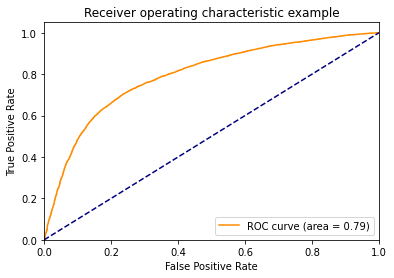


ROC Score:
0.7941513939009891

---------------

Logistic regression with polynomial features
Precision Score:
0.7464759099516095

Recall Score:
0.7023656339701079

F1-Score:
0.7237492987913714

Confusion Matrix:

        Healthy Sick
Healthy      TN   FP
Sick         FN   TP

         Healthy  Sick
Healthy     8056  2410
Sick        3007  7096



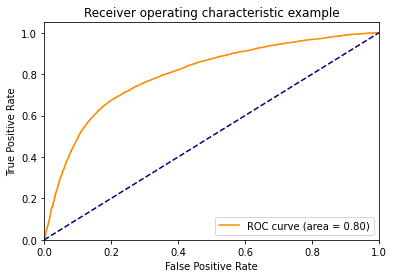


ROC Score:
0.7991754345490824


In [12]:
print('Logistic regression:')
show_evaluation(y_test, y_pred, y_prob)
print('\n---------------\n')
print('Logistic regression with polynomial features')
show_evaluation(y_test, y_pred_pol, y_prob_pol)